# SQL Agent con Langgraph

In questo notebook provo a creare un AI Agent che mappa una richiesta di un utente, espressa in linguaggio naturale, in una query SQL, utilizzando lo schema del DB. <br>
Tale query viene eseguita su DB per consentire di restituire una risposta in linguaggio naturale all'utente.

Di seguito gli step di cui si compone il workflow:
- viene estratto l'ID dell'utente
- si verifica che la richiesta sia rilevante rispetto allo schema del DB
- se non rilevante, viene restituita una risposta "simpatica"
- se rilevante, viene generata la corrispondente query SQL
- viene eseguita la query
- in caso di errore viene rigenerata ed eseguita fino ad un max numero di volte
- in caso di esito positivo, viene generata una risposta per l'utente

#### N.B.
L'esecuzione di questo notebook presuppone la precedente esecuzione di setup_db.py per la creazione e il popolamento del DB SQLlite

DA : https://www.youtube.com/watch?v=yRicPGSGuZE&t=763s

Come primo step importo le classi di SQLAlchemy che vengono utilizzate per la connessione al DB e per il mapping tra le tabelle del DB e le classi Python. Si tratta delle stesse classi già utilizzati in setup_db.py per creare il database

In [35]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float
from sqlalchemy.orm import sessionmaker, relationship, declarative_base
from langchain_core.runnables.config import RunnableConfig

load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL", "sqlite:///esempio.db")
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

Base = declarative_base()

# Definition of the Users table
class User(Base):
    __tablename__ = "users"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)
    age = Column(Integer)
    email = Column(String, unique=True, index=True)

    orders = relationship("Order", back_populates="user")

# Definition of the Food table
class Food(Base):
    __tablename__ = "food"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, unique=True, index=True)
    price = Column(Float)

    orders = relationship("Order", back_populates="food")

# Definition of the Orders table
class Order(Base):
    __tablename__ = "orders"

    id = Column(Integer, primary_key=True, index=True)
    food_id = Column(Integer, ForeignKey("food.id"))
    user_id = Column(Integer, ForeignKey("users.id"))

    user = relationship("User", back_populates="orders")
    food = relationship("Food", back_populates="orders")

## Creazione Agent
Inizio a creare l'Agent vero e proprio definendo:
- l'LLM che verrà utilizzato come modello per i diversi step del processo.
- lo stato che verrà passato tra i diversi nodi

In [36]:
import os
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
#from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, END


local_llm = "llama3.2"
#local_llm = "MFDoom/deepseek-r1-tool-calling"

# Definisco lo stato che verrà utilizzato per passare le informazioni tra i diversi nodi 

class AgentState(TypedDict):
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool

Definisco una funzione che, utilizzando le funzionalità di SQLAlchemy, estrae le informazioni relative alla struttura del DB e le formatta per una più facile comprensione da parte dell'LLM. Tale funzione verrà utilizzata successivamente all'interno di diversi nodi

In [37]:
def get_database_schema(engine):
    inspector = inspect(engine)
    schema = ""
    for table_name in inspector.get_table_names():
        schema += f"Table: {table_name}\n"
        for column in inspector.get_columns(table_name):
            col_name = column["name"]
            col_type = str(column["type"])
            if column.get("primary_key"):
                col_type += ", Primary Key"
            if column.get("foreign_keys"):
                fk = list(column["foreign_keys"])[0]
                col_type += f", Foreign Key to {fk.column.table.name}.{fk.column.name}"
            schema += f"- {col_name}: {col_type}\n"
        schema += "\n"
    print("Retrieved database schema.")
    print(schema)
    return schema

Definisco la funzione per estrarre le informazioni relative all'utente che sta utilizzando l'Agent. <br>
La funzione riceve come argomento la configurazione che consente di passare informazioni dinamiche a runtime. Nel nostro caso viene passato l'ID dello user e la funzione estrae dalla tabella User il nome dell'utente e lo inserisce nello stato che viene passato al nodo successivo

In [52]:
# Definisto il Pydantic model per il current_user in modo da poter avere structured output (in questo caso non utilizzato)
class GetCurrentUser(BaseModel):
    current_user: str = Field(
        description="The name of the current user based on the provided user ID."
    )

def get_current_user(state: AgentState, config: RunnableConfig):
    print("Retrieving the current user based on user ID.")
    user_id = config["configurable"].get("current_user_id", None)
    if not user_id:
        state["current_user"] = "User not found"
        print("No user ID provided in the configuration.")
        return state

    session = SessionLocal()
    try:
        user = session.query(User).filter(User.id == int(user_id)).first()
        if user:
            state["current_user"] = user.name
            print(f"Current user set to: {state['current_user']}")
        else:
            state["current_user"] = "User not found"
            print("User not found in the database.")
    except Exception as e:
        state["current_user"] = "Error retrieving user"
        print(f"Error retrieving user: {str(e)}")
    finally:
        session.close()
    return state

Definisco la funzione per verificare se la domanda inserita è rilevante per il DataBase in oggetto.<BR> La rilevanza è ottenuta confrontando la domanda inserita con la struttura dello schema estratto dal DB

In [39]:
# Definisto il Pydantic model in modo da poter avere structured output dall'LLM
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: AgentState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to a database schema.
    A question is considered relevant if it contains words or subject that are contained in the schema's element (tables or columns).
    This is the Database schema:

Schema:
{schema}

Respond with only "relevant" or "not_relevant".
""".format(schema=schema)
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = ChatOllama(model=local_llm, temperature=0)

    # Invoco llm con structured output passando il pydantic model che voglio come risultato
    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    relevance = relevance_checker.invoke({})
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

In [ ]:
Definisco la funzione per convertire la domanda in linguaggio naturale in query SQL.

In [53]:
# Definisto il Pydantic model in modo da poter avere structured output dall'LLM
class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

def convert_nl_to_sql(state: AgentState, config: RunnableConfig):
    question = state["question"]
    current_user = state["current_user"]
    schema = get_database_schema(engine)
    print(f"Converting question to SQL for user '{current_user}': {question}")
    system = """You are an assistant that converts natural language questions into SQL queries based on the following schema:

{schema}

The current user is '{current_user}'. Ensure that all query-related data is scoped to this user.
Provide only the SQL query without any explanations. Alias columns appropriately to match the expected keys in the result.
For example, alias 'food.name' as 'food_name' and 'food.price' as 'price
The answer must contain only sql code without explanation or other text'.

""".format(schema=schema, current_user=current_user)
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    llm = ChatOllama(model=local_llm, temperature=0)
    # Anche in questo caso invoco LLM con structured output passando il pydantic model con la struttura della risposta
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | llm
    result = sql_generator.invoke({"question": question})

    ## Dal momento che llama2 NON rispetta lo structured output come OpenAI, devo estrarre la query dal content e non dal campo sql_query
    # come previsto da structured output. Inoltre devo ripulire il content dai caratteri "particolari".
    print(f"result : {result.content.replace('sql','').replace('```','')}")
    state["sql_query"] = result.content.replace('sql','').replace('```','')
    # OpenAI avrebbe restituito lo structured output previsto
#    state["sql_query"] = result.sql_query
    print(f"Generated SQL query: {state['sql_query']}")
    return state

Definisco la funzione che ricava dallo stato la query creata allo step precedente e la esegue sul Database. <br>
Dal momento che consente di eseguire comandi direttamente sul DB è necessario porre particolare attenzione a non eseguire in ambienti di produzione. Sarebbe necessario verificare di eseguire solo comandi "select".<BR>
A seconda della presenza di errori in fase di esecuzione. setta nello stato il campo sql_error per consentire ai successivi nodi di gestire eventuali errori

In [41]:
def execute_sql(state: AgentState):
    sql_query = state["sql_query"].strip()
    session = SessionLocal()
    print(f"Executing SQL query: {sql_query}")
    try:
        result = session.execute(text(sql_query))
        if sql_query.lower().startswith("select"):
            rows = result.fetchall()
            columns = result.keys()
            if rows:
                header = ", ".join(columns)
                state["query_rows"] = [dict(zip(columns, row)) for row in rows]
                print(f"Raw SQL Query Result: {state['query_rows']}")
                # Formattazione dell'output per consentire una più facile interpretazione dal parte dell'LLM
                data = "; ".join([f"{row.get('food_name', row.get('name'))} for ${row.get('price', row.get('food_price'))}" for row in state["query_rows"]])
                formatted_result = f"{header}\n{data}"
            else:
                state["query_rows"] = []
                formatted_result = "No results found."
            state["query_result"] = formatted_result
            state["sql_error"] = False
            print("SQL SELECT query executed successfully.")
        else:
            session.commit()
            state["query_result"] = "The action has been successfully completed."
            state["sql_error"] = False
            print("SQL command executed successfully.")
    except Exception as e:
        state["query_result"] = f"Error executing SQL query: {str(e)}"
        state["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
    finally:
        session.close()
    return state

Definisco la funzione per generare la risposta in linguaggio naturale a seguito dell'esecuzione della query.<br>
Il promt è diverso a seconda se:
- c'è stato un errore nell'esecuzione della query
- la query contiene una select che ha fornito un risultato
- la query contiene una select che non ha fornito un risultato
- la query contiene uno statement diverso da select

In [42]:
def generate_human_readable_answer(state: AgentState):
    sql = state["sql_query"]
    result = state["query_result"]
    current_user = state["current_user"]
    query_rows = state.get("query_rows", [])
    sql_error = state.get("sql_error", False)
    print("Generating a human-readable answer.")
    system = """You are an assistant that converts SQL query results into clear, natural language responses without including any identifiers like order IDs.
                Start the response with a friendly greeting that includes the user's name.
    """
    if sql_error:
        # Directly relay the error message
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable error message in a single sentence, starting with 'Hello {current_user},' informing them about the issue."""
                ),
            ]
        )
    elif sql.lower().startswith("select"):
        if not query_rows:
            # Handle cases with no orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, starting with 'Hello {current_user},' and mention that there are no orders found."""
                    ),
                ]
            )
        else:
            # Handle displaying orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, starting with 'Hello {current_user},' and list each item ordered along with its price. For example: 'Hello Bob, you have ordered Lasagne for $14.0 and Spaghetti Carbonara for $15.0.'"""
                    ),
                ]
            )
    else:
        # Handle non-select queries
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable confirmation message in a single sentence, starting with 'Hello {current_user},' confirming that your request has been successfully processed."""
                ),
            ]
        )

    llm = ChatOllama(model=local_llm, temperature=0)
    human_response = generate_prompt | llm | StrOutputParser()
    answer = human_response.invoke({})
    state["query_result"] = answer
    print("Generated human-readable answer.")
    return state

In caso di errore nell'esecuzione della query, definisco la funzione per ri-generare una differente domanda al fine di consentire la successiva generazione di una nuova query.<br>
In questa funzione procedo anche ad incrementare la variabile all'interno dello stato che contiene in numero di tentativi. Questo al fine di impedire loop di errore infiniti

In [54]:
# Definisto il Pydantic model in modo da poter avere structured output dall'LLM
class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: AgentState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """You are an assistant that reformulates an original question to enable more precise SQL queries. 
    Ensure that all necessary details, such as table joins, are preserved to retrieve complete and accurate data.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"Original Question: {question}\nReformulate the question to enable more precise SQL queries, ensuring all necessary details are preserved.",
            ),
        ]
    )
    llm = ChatOllama(model=local_llm, temperature=0)
    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm
    rewritten = rewriter.invoke({})
    state["question"] = rewritten.question
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    return state

Definisco una funzione per generare una risposta "simpatica" nel caso la domanda inserita non sia rilevante con la struttura del Database

In [44]:
def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """You are a charming and funny assistant who responds in a playful manner.
    """
    human_message = "I can not help with that, but doesn't asking questions make you hungry? You can always order something delicious."
    funny_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_message),
        ]
    )
    llm = ChatOllama(model=local_llm, temperature=0.7)
    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["query_result"] = message
    print("Generated funny response.")
    return state

Definisco l'ultima "node function" per terminare il flow nel caso di superamento del numero massimo di tentativi

In [55]:
def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

Definisco le router function che definiscono i nodi successivi sulla base di test su variabili contenute nello stato

In [45]:
def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "generate_funny_response"

def check_attempts_router(state: AgentState):
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iterations"

def execute_sql_router(state: AgentState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"

In [46]:
workflow = StateGraph(AgentState)

workflow.add_node("get_current_user", get_current_user)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("end_max_iterations", end_max_iterations)

workflow.add_edge("get_current_user", "check_relevance")

workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "generate_funny_response": "generate_funny_response",
    },
)

workflow.add_edge("convert_to_sql", "execute_sql")

workflow.add_conditional_edges(
    "execute_sql",
    execute_sql_router,
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query",
    },
)

workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_to_sql": "convert_to_sql",
        "max_iterations": "end_max_iterations",
    },
)

workflow.add_edge("generate_human_readable_answer", END)
workflow.add_edge("generate_funny_response", END)
workflow.add_edge("end_max_iterations", END)

workflow.set_entry_point("get_current_user")

app = workflow.compile()

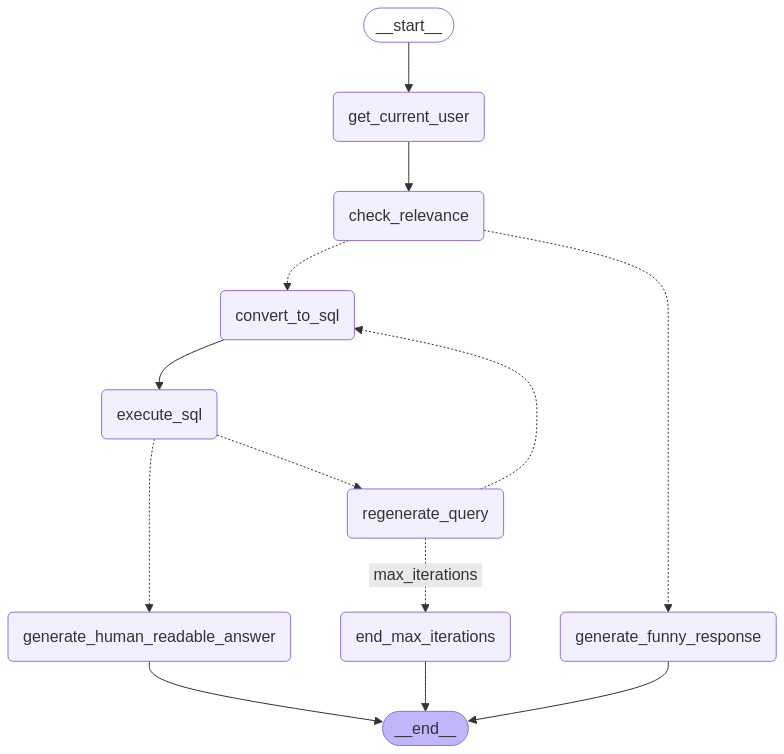

In [47]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [48]:
fake_config = {"configurable": {"current_user_id": "2"}}

In [49]:
user_question_1 = "Create a new order for Spaghetti Carbonara."
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])

Retrieving the current user based on user ID.
Current user set to: Bob
Retrieved database schema.
Table: food
- id: INTEGER, Primary Key
- name: VARCHAR
- price: FLOAT

Table: orders
- id: INTEGER, Primary Key
- food_id: INTEGER
- user_id: INTEGER

Table: users
- id: INTEGER, Primary Key
- name: VARCHAR
- age: INTEGER
- email: VARCHAR


Checking relevance of the question: Create a new order for Spaghetti Carbonara.
Relevance determined: relevant
Retrieved database schema.
Table: food
- id: INTEGER, Primary Key
- name: VARCHAR
- price: FLOAT

Table: orders
- id: INTEGER, Primary Key
- food_id: INTEGER
- user_id: INTEGER

Table: users
- id: INTEGER, Primary Key
- name: VARCHAR
- age: INTEGER
- email: VARCHAR


Converting question to SQL for user 'Bob': Create a new order for Spaghetti Carbonara.
result : 
INSERT INTO orders (food_id, user_id)
SELECT f.id, u.id
FROM food f
JOIN users u ON u.id = ?
WHERE f.name = 'Spaghetti Carbonara';

Generated SQL query: 
INSERT INTO orders (food_id, us

In [50]:
def get_orders_for_user(user_id: int):
    session = SessionLocal()
    try:
        orders = (
            session.query(Order)
            .join(Food, Order.food_id == Food.id)
            .filter(Order.user_id == user_id)
            .all()
        )
        if not orders:
            print(f"No orders found for user_id {user_id}.")
            return []

        order_list = []
        for order in orders:
            order_info = {
                "order_id": order.id,
                "food_name": order.food.name,
                "price": order.food.price
            }
            order_list.append(order_info)

        return order_list
    except Exception as e:
        print(f"Error retrieving orders for user_id {user_id}: {e}")
        return []
    finally:
        session.close()

orders = get_orders_for_user(1)
orders

[{'order_id': 1, 'food_name': 'Pizza Margherita', 'price': 12.5},
 {'order_id': 2, 'food_name': 'Spaghetti Carbonara', 'price': 15.0},
 {'order_id': 4, 'food_name': 'Spaghetti Carbonara', 'price': 15.0},
 {'order_id': 5, 'food_name': 'Spaghetti Carbonara', 'price': 15.0},
 {'order_id': 6, 'food_name': 'Spaghetti Carbonara', 'price': 15.0},
 {'order_id': 7, 'food_name': 'Spaghetti Carbonara', 'price': 15.0},
 {'order_id': 8, 'food_name': 'Spaghetti Carbonara', 'price': 15.0},
 {'order_id': 9, 'food_name': 'Spaghetti Carbonara', 'price': 15.0},
 {'order_id': 10, 'food_name': 'Spaghetti Carbonara', 'price': 15.0}]

In [9]:
user_question_2 = "Tell me a joke."
result_2 = app.invoke({"question": user_question_2, "attempts": 0}, config=fake_config)
print("Result:", result_2["query_result"])

Retrieving the current user based on user ID.
Current user set to: Bob
Retrieved database schema.
Checking relevance of the question: Tell me a joke.
Relevance determined: not_relevant
Generating a funny response for an unrelated question.
Generated funny response.
Result: You think I'm a foodie already, huh? Well, I suppose it's only fair to ask for some virtual snacks. *rumbles tummy* In that case, I'll take a big plate of "Byte-Sized" burgers and fries... just kidding! Or am I?

Seriously though, thanks for the offer, but I'm always here to help, hunger-free (virtual or not!). What's on your mind? Need some assistance or just want to chat?


In [51]:
user_question_3 = "Is it possible to order Pizza Margherita?"
result_3 = app.invoke({"question": user_question_3, "attempts": 0}, config=fake_config)
print("Result:", result_3["query_result"])

Retrieving the current user based on user ID.
Current user set to: Bob
Retrieved database schema.
Table: food
- id: INTEGER, Primary Key
- name: VARCHAR
- price: FLOAT

Table: orders
- id: INTEGER, Primary Key
- food_id: INTEGER
- user_id: INTEGER

Table: users
- id: INTEGER, Primary Key
- name: VARCHAR
- age: INTEGER
- email: VARCHAR


Checking relevance of the question: Is it possible to order Pizza Margherita?
Relevance determined: relevant
Retrieved database schema.
Table: food
- id: INTEGER, Primary Key
- name: VARCHAR
- price: FLOAT

Table: orders
- id: INTEGER, Primary Key
- food_id: INTEGER
- user_id: INTEGER

Table: users
- id: INTEGER, Primary Key
- name: VARCHAR
- age: INTEGER
- email: VARCHAR


Converting question to SQL for user 'Bob': Is it possible to order Pizza Margherita?
result : 
SELECT *
FROM food f
JOIN orders o ON f.id = o.food_id
WHERE o.user_id = (SELECT id FROM users WHERE name = 'Bob')
AND f.name = 'Pizza Margherita';

Generated SQL query: 
SELECT *
FROM food